# Validation
Three goals:

 - Check where the reads of our target studies (Crits-Christoph, Rothman, Spurbeck, and Brinch) end up.

 - Check if there is some bias in which viral species have worse or better scores. Understanding the makeup of the left side of the distribution but got bogged down by results that couldn’t be right. I will pick up on this tomorrow, though I will first work on point 1 as that seems more important.
 - Check validity of BowTie2 results
 - Cross-check BowTie2 results with Jeff’s original validation results.

In [263]:
import pysam
import os
import json
import matplotlib.pyplot as plt
from math import sqrt
import pandas as pd

In [264]:
dashboard = os.path.expanduser("~/code/mgs-pipeline/dashboard/")

with open(os.path.join(dashboard, "human_virus_sample_counts.json")) as inf:
    human_virus_sample_counts = json.load(inf)

with open(os.path.join(dashboard, "metadata_samples.json")) as inf:
    metadata_samples = json.load(inf)

with open(os.path.join(dashboard, "metadata_bioprojects.json")) as inf:
    metadata_bioprojects = json.load(inf)

with open(os.path.join(dashboard, "metadata_papers.json")) as inf:
    metadata_papers = json.load(inf)

with open(os.path.join(dashboard, "taxonomic_names.json")) as inf:
    taxonomic_names = json.load(inf)


studies = list(metadata_papers.keys())

In [265]:
hvsams_directory_path = "hvsams"

fastq_read_entries = 0
for filename in os.listdir('hvfastqs'):
    with open(f'hvfastqs/{filename}') as f:
        for line in f:
            if line.startswith("@"):
                fastq_read_entries += 1
sam_entries = 0

for filename in os.listdir('hvsams'):
    sam_file = pysam.AlignmentFile(hvsams_directory_path + "/" + filename, "r")
    for read in sam_file.fetch():
        sam_entries += 1

print(fastq_read_entries, sam_entries)



57111 57054


In [266]:
metadata_samples["SRR14530757"]

{'country': 'United States',
 'county': 'Los Angeles County',
 'date': '2020-09-01',
 'enrichment': 'panel',
 'fine_location': 'HTP',
 'location': 'Los Angeles',
 'reads': 4286417,
 'state': 'California'}

## Understanding overall alignment score quality distribution

In [267]:
refseq_directory_path = "raw-genomes"

refseq_id_and_names = {}

for filename in os.listdir(refseq_directory_path):
    with open(os.path.join(refseq_directory_path, filename)) as inf:
        for line in inf:
            if line.startswith(">"):
                identifier, description = line[1:].split(" ", 1)
                identifier = str(identifier.strip())
                name = description.split(",", 1)[0].strip()
                refseq_id_and_names[identifier] = name
            else:
                continue

In [268]:
sam_records = []

hvsams_directory_path = "hvsams"

for filename in os.listdir(hvsams_directory_path):
    sam_file = pysam.AlignmentFile(hvsams_directory_path + "/" + filename, "r")
    for read in sam_file.fetch():
        read_id = read.query_name
        sequence = read.query_sequence
        read_length = read.query_length

        try:
            alignment_score = read.get_tag("AS")
            length_adjusted_alignment_score = alignment_score / sqrt(read_length)
            sam_records.append(
                [
                    read_id,
                    sequence,
                    alignment_score,
                    length_adjusted_alignment_score,
                ]
            )
        except:
            alignment_score = 0
            length_adjusted_alignment_score = 0
            sam_records.append(
                [
                    read_id,
                    sequence,
                    alignment_score,
                    length_adjusted_alignment_score,
                ]
            )


In [269]:
df = pd.DataFrame(sam_records, columns=["read_id", "sequence", "alignment_score", "length_adjusted_alignment_score"])

In [281]:
print(len(df[df["alignment_score"] == 0]), len(df[df["alignment_score"] > 0]))

19248 37806


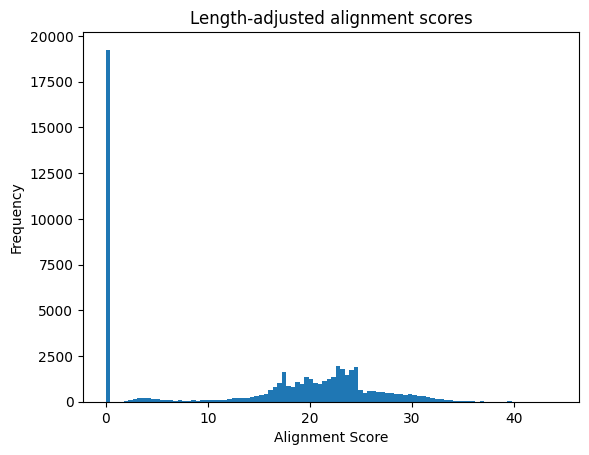

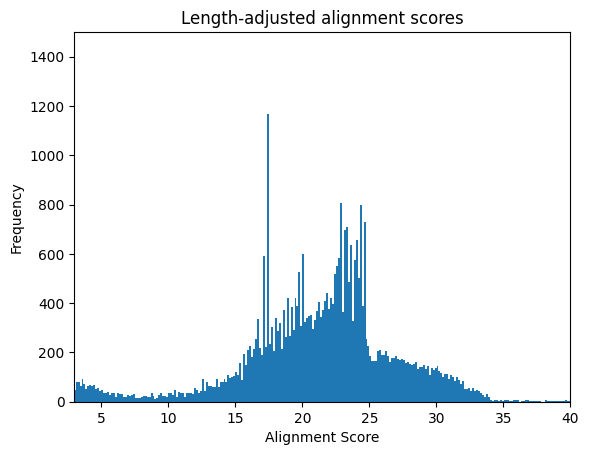

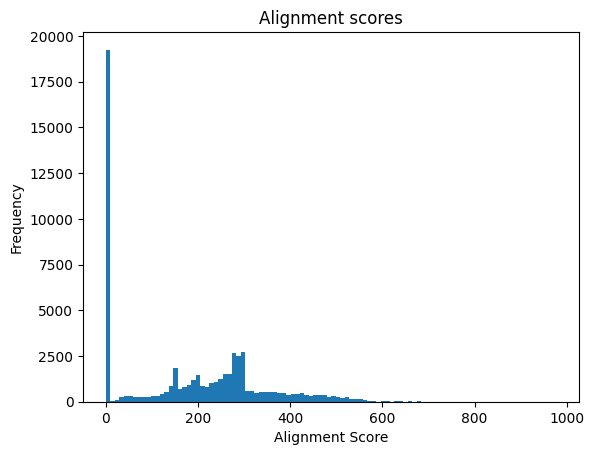

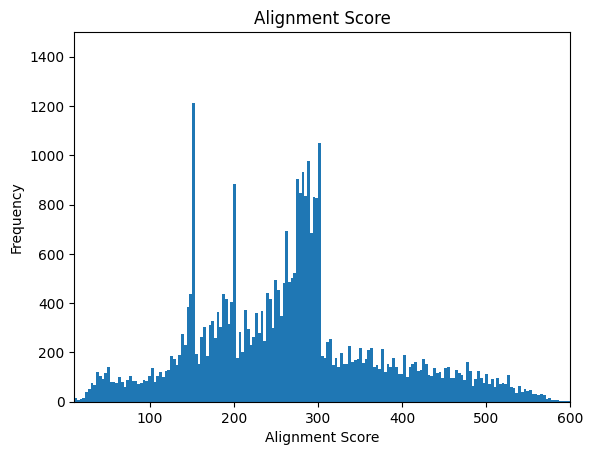

<Figure size 640x480 with 0 Axes>

In [278]:





import matplotlib.pyplot as plt  # re-importing to reset xlim

plt.hist(df["length_adjusted_alignment_score"], bins=100)
plt.title("Length-adjusted alignment scores")
plt.xlabel("Alignment Score")
plt.ylabel("Frequency")
plt.show()
plt.clf()



plt.hist(df["length_adjusted_alignment_score"], bins=300)

plt.title("Length-adjusted alignment scores")
plt.xlabel("Alignment Score")
plt.xlim(3, 40)
plt.ylim(0,1500)
plt.ylabel("Frequency")
plt.show()
plt.clf()

plt.hist(df["alignment_score"], bins=100)
plt.title("Alignment scores")
plt.xlabel("Alignment Score")
plt.ylabel("Frequency")
plt.show()
plt.clf()



plt.hist(df["alignment_score"], bins=300)

plt.xlim(10,600)
plt.ylim(0,1500)
plt.title("Alignment Score")
plt.xlabel("Alignment Score")
plt.ylabel("Frequency")
plt.show()
plt.clf()

In [ ]:
# fully print all values
pd.options.display.max_colwidth = 300

alignment_score_30_sub_sample = df[df["alignment_score"].round() == 30].sample(n=20, random_state=1)

# get shape of alignment_score_5_sub_sample

alignment_score_100_sub_sample = df[df["alignment_score"].round() == 100].sample(n=20, random_state=1)



concatenated_samples = pd.concat([alignment_score_30_sub_sample, alignment_score_100_sub_sample])

# Save the data to a CSV file
concatenated_samples.to_csv('alignment_sample.csv', index=False)

In [ ]:

def find_sam_entry(entry):
    directory_path = 'hvsams'
    try:
        if entry.startswith("M"):
            file_id  = entry.split('_')[1].split('.')[0]
        else:
            file_id = entry.split('.')[0]

        full_filename = file_id + '.sam'

        file_path = os.path.join(directory_path, full_filename)


        with open(file_path, 'r') as file:
            results = []
            for line in file:
                sam_entry = str(line.split('\t')[0].strip())

                if sam_entry == entry:
                    results.append(line)
            
        if not results:
            return "Entry not found."
        else:
            return results[0], results[1]
    except FileNotFoundError:
        return "File not found."
    except Exception as e:
        return f"An error occurred: {str(e)}"


    

In [ ]:

print(find_sam_entry("SRR14530849.193358"))

('SRR14530849.193358\t77\t*\t0\t0\t*\t*\t0\t0\tGTGTACCATCTGTTTTTACGATATCATCTACAAAACAGCCGGCCCCTAGGATTCTTGATGGATCTGCTGTCTCTTATACACATCTCCGAGCCCACGAGACA\tF,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFF:FFFFFFFFFF:FFFFFFFFFFFFFFFFFF\tYT:Z:UP\n', 'SRR14530849.193358\t141\t*\t0\t0\t*\t*\t0\t0\tCAGATCCATCAAGAATCCTAGGGGCCGGCTGTTTTGTAGATGATATCGTAAAAACAGATGGTACACCTGTCTCTTATACACATCTGACGCTGCCGACGAAT\tFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFF\tYT:Z:UP\n')


# Cross-checking BowTie2 alignments with Kraken assigments.

In [ ]:
# example SSR: SRR14530724 with bioproject PRJNA729801



In [ ]:
brinch_samples = []
for study in studies:
    if study not in [
        "Brinch 2020",  
    ]:
        continue
    
    for bioproject in metadata_papers[study]["projects"]:
        samples = metadata_bioprojects[bioproject]

        # set all samples to strin type
        samples = [str(sample) for sample in samples]
        brinch_samples.extend(samples)


rothman_samples = []
for study in studies:
    if study not in [
        "Rothman 2021",  # unpublished data
    ]:
        continue
    
    for bioproject in metadata_papers[study]["projects"]:
        samples = metadata_bioprojects[bioproject]

        # set all samples to strin type
        samples = [str(sample) for sample in samples]
        rothman_samples.extend(samples)

print(rothman_samples)



spurbeck_samples = []
for study in studies:
    if study == "Spurbeck 2023":
        for bioproject in metadata_papers[study]["projects"]:
            samples = metadata_bioprojects[bioproject]

            # set all samples to strin type
            samples = [str(sample) for sample in samples]
            spurbeck_samples.extend(samples)


['SRR14530724', 'SRR14530725', 'SRR14530726', 'SRR14530727', 'SRR14530728', 'SRR14530729', 'SRR14530730', 'SRR14530731', 'SRR14530732', 'SRR14530733', 'SRR14530734', 'SRR14530735', 'SRR14530736', 'SRR14530737', 'SRR14530738', 'SRR14530739', 'SRR14530740', 'SRR14530741', 'SRR14530742', 'SRR14530743', 'SRR14530744', 'SRR14530745', 'SRR14530746', 'SRR14530747', 'SRR14530748', 'SRR14530749', 'SRR14530750', 'SRR14530751', 'SRR14530752', 'SRR14530753', 'SRR14530754', 'SRR14530755', 'SRR14530756', 'SRR14530757', 'SRR14530758', 'SRR14530759', 'SRR14530760', 'SRR14530761', 'SRR14530762', 'SRR14530763', 'SRR14530764', 'SRR14530765', 'SRR14530766', 'SRR14530767', 'SRR14530768', 'SRR14530769', 'SRR14530770', 'SRR14530771', 'SRR14530772', 'SRR14530773', 'SRR14530774', 'SRR14530775', 'SRR14530776', 'SRR14530777', 'SRR14530778', 'SRR14530779', 'SRR14530780', 'SRR14530781', 'SRR14530782', 'SRR14530783', 'SRR14530784', 'SRR14530785', 'SRR14530786', 'SRR14530787', 'SRR14530788', 'SRR14530789', 'SRR14530

In [ ]:
print(spurbeck_samples)

['SRR23083716', 'SRR23083718', 'SRR23083720', 'SRR23083722', 'SRR23083725', 'SRR23083727', 'SRR23083729', 'SRR23083731', 'SRR23083733', 'SRR23083734', 'SRR23083736', 'SRR23083738', 'SRR23083740', 'SRR23083742', 'SRR23083744', 'SRR23083747', 'SRR23083749', 'SRR23083751', 'SRR23083753', 'SRR23083755', 'SRR23083756', 'SRR23083758', 'SRR23083760', 'SRR23083762', 'SRR23083764', 'SRR23083766', 'SRR23083769', 'SRR23083771', 'SRR23083773', 'SRR23083775', 'SRR23083778', 'SRR23083780', 'SRR23083782', 'SRR23083784', 'SRR23083786', 'SRR23083787', 'SRR23083789', 'SRR23083790', 'SRR23083792', 'SRR23083794', 'SRR23083795', 'SRR23083797', 'SRR23083798', 'SRR23083799', 'SRR23083801', 'SRR23083804', 'SRR23083806', 'SRR23083808', 'SRR23083810', 'SRR23083813', 'SRR23083818', 'SRR23083820', 'SRR23083822', 'SRR23083823', 'SRR23083825']


In [ ]:
# from df, drop all rows that do not have a sample_id, present in brinch_samples

df_brinch = df[df["sample_id"].isin(brinch_samples)]
print(df_brinch[df_brinch["reference_name"] == "No Alignment"].shape[0])

print(df_brinch.shape[0])

df_rothman = df[df["sample_id"].isin(rothman_samples)]

print(df_rothman[df_rothman["reference_name"] == "No Alignment"].shape[0])

print(df_rothman.shape[0])

df_spurbeck = df[df["sample_id"].isin(spurbeck_samples)]



KeyError: 'sample_id'

In [ ]:
# size of df
print(df.shape)

(17716, 5)


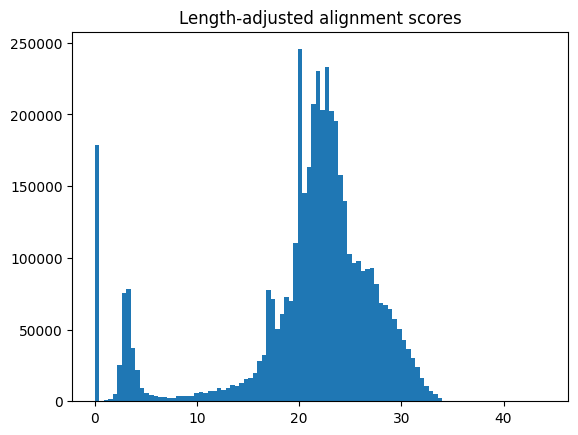

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.hist(list(read_score_all.values()), bins=100)
plt.title("Length-adjusted alignment scores")
plt.show()
plt.clf()

## Cross-check BowTie2 results with Jeff’s original validation results.

Exluded reads can be found in `excluded_read_ids.txt`. Let's look at their alignment scores.

In [ ]:
excluded_read_id_scores = {}
with open("excluded_read_ids.txt") as inf:
    for line in inf:
        read_id = line.strip()
        alignment_score = read_score_dict[read_id]
        excluded_read_id_scores[read_id] = alignment_score

        

In [ ]:
for read_id, alignment_score in excluded_read_id_scores.items():
    if alignment_score > 7:
        print(read_id)

ERR3563089.9818664


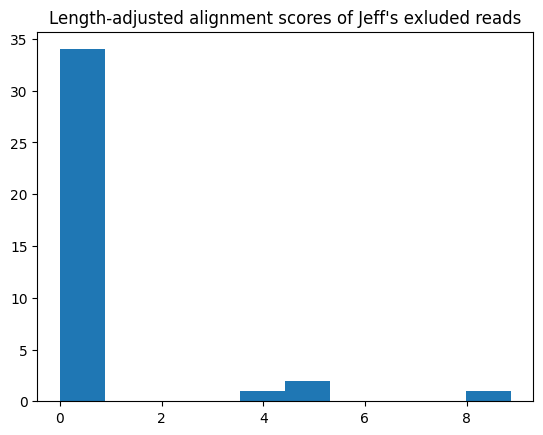

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.hist(list(excluded_read_id_scores.values()), bins=10)
plt.title("Length-adjusted alignment scores of Jeff's exluded reads")
plt.show()
plt.clf()

## Check alignment scores of target study reads

In [ ]:

target_samples = []
for study in studies:
    if study not in [
        "Brinch 2020",  # unpublished data
        "Crits-Christoph 2021",  # untreated undigested sludge
        "Rothman 2021",
        "Spurbeck 2023",
    ]:
        continue
    
    for bioproject in metadata_papers[study]["projects"]:
        samples = metadata_bioprojects[bioproject]

        if study == "Bengtsson-Palme 2016":
            samples = [
                sample
                for sample in samples
                if metadata_samples[sample]["fine_location"].startswith("Inlet")
            ]

        if study == "Ng 2019":
            samples = [
                sample
                for sample in samples
                if metadata_samples[sample]["fine_location"] == "Influent"
            ]

        # set all samples to strin type
        samples = [str(sample) for sample in samples]
        target_samples.extend(samples)

In [ ]:
read_score_dict = {}

sam_target_files = []
missing_samples = set()

hvsams_directory_path = "hvsams"

n_failed_alignments = 0

for filename in os.listdir(hvsams_directory_path):
    if filename.endswith(".sam"):
        sample_id, _, = filename.split(".")
        sample_id = str(sample_id)
        if sample_id not in target_samples:
            missing_samples.add(sample_id)
            continue
        sam_target_files.append(sample_id)
        with open(hvsams_directory_path + "/" + filename) as inf:
            for line in inf:
                if line.startswith("@"):
                    continue
                else:
                    line_split = line.split("\t")

                    read_id = line_split[0]
                    reference_sequence = str(line_split[2])
                    if reference_sequence == "*":
                        alignment_score = 0 # no aligment found
                        read_score_dict[read_id] = alignment_score
                        n_failed_alignments += 1
                        continue
                
                    read_length = len(line_split[9])

                    optional_fields_dict = {}
                    for field in line_split[11:]:
                        key, _, value = field.split(":")
                        optional_fields_dict[key] = value

                    if "AS" in optional_fields_dict:
                        alignment_score = int(optional_fields_dict["AS"])
                        read_score_dict[read_id] = alignment_score / sqrt(read_length)

                    else: # no aligment performed
                        alignment_score = 0
                        n_failed_alignments += 1
                        read_score_dict[read_id] = alignment_score

Some target samples are missing in the SAM files. This happens, because some samples have no human reads; hence they produce no `{sample_id}.hvreads.json`file

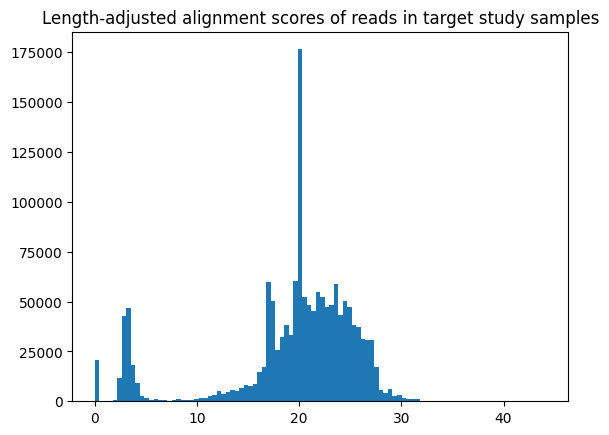

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.hist(list(read_score_dict.values()), bins=100)
plt.title("Length-adjusted alignment scores of reads in target study samples")
plt.show()
plt.clf()

In [ ]:
reference_read_score = []


hvsams_directory_path = "hvsams"

n_failed_alignments = 0

for filename in os.listdir(hvsams_directory_path):
    if filename.endswith(".sam"):
        sample_id, _, = filename.split(".")
        sample_id = str(sample_id)
        if sample_id not in target_samples:
            missing_samples.add(sample_id)
            continue

        with open(hvsams_directory_path + "/" + filename) as inf:
            for line in inf:
                if line.startswith("@"):
                    continue
                else:
                    line_split = line.split("\t")

                    read_id = line_split[0]
                    reference_sequence = str(line_split[2])



                    if reference_sequence == "*":
                        alignment_score = 0 # no aligment found
                        read_score_dict[read_id] = alignment_score
                        reference_read_score.append([reference_sequence, read_id, alignment_score])
                        
                        continue
                
                    read_length = len(line_split[9])

                    optional_fields_dict = {}
                    for field in line_split[11:]:
                        key, _, value = field.split(":")
                        optional_fields_dict[key] = value

                    if "AS" in optional_fields_dict:
                        alignment_score = int(optional_fields_dict["AS"])
                        length_adj_alignment_score = alignment_score / sqrt(read_length)
                        reference_read_score.append([reference_sequence, read_id, length_adj_alignment_score])

                    else: # no aligment performed
                        alignment_score = 0
                        
                        reference_read_score.append([reference_sequence, read_id, alignment_score])
                        

In [ ]:
refseq_directory_path = "raw-genomes"

refseq_id_and_names = {}

for filename in os.listdir(refseq_directory_path):
    with open(os.path.join(refseq_directory_path, filename)) as inf:
        for line in inf:
            if line.startswith(">"):
                identifier, description = line[1:].split(" ", 1)
                identifier = str(identifier.strip())
                name = description.split(",", 1)[0]
                refseq_id_and_names[identifier] = name.strip()
            else:
                continue

In [ ]:
df = pd.DataFrame(reference_read_score, columns =['reference_id', 'read_id', 'alignment_score'])

In [ ]:
# add a column with the name of the reference sequence
df['reference_name'] = df['reference_id'].map(refseq_id_and_names)

In [ ]:
df[df['reference_id'] == 'NC_045512.2']['read_id']

142          SRR18341114.10472838
143          SRR18341114.10472838
144          SRR18341114.10560687
145          SRR18341114.10560687
146          SRR18341114.10667381
                    ...          
1951178    M_SRR18341119.31579725
1951497    M_SRR18341119.39376495
1951499    M_SRR18341119.39405662
1951764    M_SRR18341119.31010563
1952308    M_SRR18341119.24554728
Name: read_id, Length: 1694955, dtype: object

In [ ]:
bad_covid_reads = []
good_covid_reads = []
for reference_id, read_id, score in reference_read_score:
    if reference_id == 'NC_045512.2':
        if score < 7:
            bad_covid_reads.append(read_id)
        else:    
            good_covid_reads.append(read_id)

In [ ]:
print(len(bad_covid_reads))
print(len(good_covid_reads))


print(len(reference_read_score))

148737
1546218
1952373


In [ ]:
print(sorted_count_below_8)

{'Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1': 150745, 'No Alignment': 28812, 'Astrovirus MLB1': 4016, 'Macacine herpesvirus 1': 2139, 'Influenza A virus (A/Puerto Rico/8/1934(H1N1)) segment 6': 1384, 'Human coronavirus OC43 strain ATCC VR-759': 1229, 'Norovirus GII': 968, 'Human bocavirus 2c PK isolate PK-5510': 820, 'SARS coronavirus Tor2': 517, 'Astrovirus MLB2': 504, 'Norovirus GII.2 strain Env/CHN/2016/GII.P16-GII.2/BJSMQ': 500, 'Macacine alphaherpesvirus 1 isolate KQ': 325, 'Human adenovirus C': 316, 'Human adenovirus type 1': 308, 'Human adenovirus F': 297, 'Human adenovirus 5': 291, 'Encephalomyocarditis virus': 274, 'Human bocavirus 3': 264, 'Papiine herpesvirus 2': 247, 'Human adenovirus E': 237, 'Human feces pecovirus strain PeCV-NI': 220, 'Norovirus GII.17': 220, 'Human bocavirus 4 NI strain HBoV4-NI-385': 220, 'Hudisavirus sp. isolate P22': 182, 'Human immunodeficiency virus 2': 175, 'Astrovirus MLB3 isolate MLB3/human/Vellore/26564/2004': 174, 'Nor

In [ ]:
# Replace keys in count_below_8 with names

